In [1]:
import basis_set_exchange as bse
import scipy as sp
import matplotlib.pyplot as plt
from pyscf import gto,scf
import copy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from pyscf.data.elements import _symbol

In [2]:
import sys
sys.path.append("./Libs")
from FcMole import FcM
from FDcoeffs import get_coeffs

In [264]:
def pcX(z,ref=None):
    if z <1.e-10: raise Exception("non implemented Zero charge atom")
    if z%1 <1.e-10:
        return gto.basis.load(bse.get_basis("pcX-1",fmt="nwchem",elements=[int(z)]),_symbol(int(z)))
    elif ref:
        rb=pcX(ref)
        rbm=pcX(ref-1)
        rbp=pcX(ref+1)
        fb=copy.deepcopy(rb)
        for i in range(len(fb)):  # ref+a(z-zr) +b(z-zr)^2
            a=(rbp[i][1][0]-rbm[i][1][0])/2
            b=(rbp[i][1][0]+rbm[i][1][0]-2*rb[i][1][0])/2
            fb[i][1][0]+=a*(z-ref)+b*abs(z-ref)**2
        return fb
    else: raise Exception("can't get the fractional charge basis set, frac val and no ref")

In [283]:
pcX(8,ref=7),pcX(7.999,ref=7)

([[0, [2610.67, 1.0]],
  [0, [392.872, 1.0]],
  [0, [89.2838, 1.0]],
  [0, [24.7795, 1.0]],
  [0, [7.56349, 1.0]],
  [0, [1.22156, 1.0]],
  [0, [0.350296, 1.0]],
  [1, [19.3002, 1.0]],
  [1, [4.19491, 1.0]],
  [1, [1.12806, 1.0]],
  [1, [0.276081, 1.0]],
  [2, [1.04881, 1.0]]],
 [[0, [2610.024744295, 1.0]],
  [0, [392.77493140949997, 1.0]],
  [0, [89.26173639224999, 1.0]],
  [0, [24.773336426949996, 1.0]],
  [0, [7.561576329709999, 1.0]],
  [0, [1.2212333587775, 1.0]],
  [0, [0.35020437761549994, 1.0]],
  [1, [19.29567272795, 1.0]],
  [1, [4.193888839135, 1.0]],
  [1, [1.1277921717185, 1.0]],
  [1, [0.2760230082635, 1.0]],
  [2, [1.0487098869859999, 1.0]]])

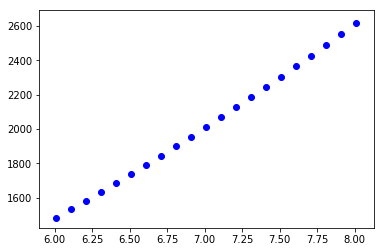

In [266]:
x=np.linspace(6.01,8.01,21)
a=[]
for i in x:
    plt.scatter(i,pcX(i,ref=7)[0][1][0],color="blue")
    a.append(pcX(i,ref=7)[1][1][0])

In [267]:
def E(l,zbs=True):
    if zbs:
        mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7-l,ref=7),"N2":pcX(7+l,ref=7)},verbose=1)
    else:
         mol_l=FcM(fcs=[-l,l],atom="N1 0 0 0; N2 0 0 2.05",unit="Bohrs",basis={"N1":pcX(7,ref=7),"N2":pcX(7,ref=7)},verbose=1)       
    mf_l=scf.RHF(mol_l)
    #mf_l.conv_tol=1e-12
    #mf_l.conv_tol_grad=1e-12
    e=mf_l.scf(dm0=mf_l.init_guess_by_1e())
    return e

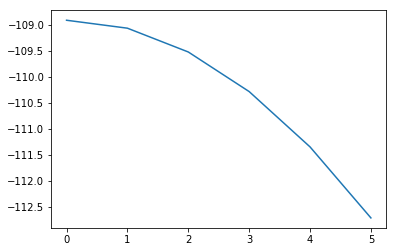

In [268]:
a=[]
for i in np.linspace(0,1,6):
    a.append(E(i))
plt.plot(a)

In [269]:
eT_R=E(-1,zbs=False)

In [270]:
.0002**1.2,-.0002**1.2

(3.641128406052162e-05, -3.641128406052162e-05)

In [271]:
e_co=scf.RHF(gto.M(atom="C 0 0 0; O 0 0 2.05",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()
e_nn=scf.RHF(gto.M(atom="N 0 0 0; N 0 0 2.05",unit="Bohrs",basis=bse.get_basis("pcX-1"\
                                                       ,fmt="nwchem",elements=["C","N","O"]))).scf()

converged SCF energy = -112.716141826715
converged SCF energy = -108.916591616523


In [272]:
#5pts finite difference coefficients
fd1=np.asarray([1/12,-2/3 ,0,2/3,-1/12])
fd2=np.asarray([-1/12,4/3,-5/2,4/3,-1/12])
fd3=np.asarray([-1/2,1,0,-1,1/2])
fd4=np.asarray([1,-4,6,-4,1])
fds=[fd1,fd2,fd3,fd4]
fds5=get_coeffs(5)
fds7=get_coeffs(7)

In [305]:
dl=.05
Es=np.asarray([E(-3*dl),E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl),E(3*dl)])
apdft=[e_nn]
inc=[]
for i in range(6):
    inc.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+inc[-1] )
apdft,e_co,inc

([-108.91659161652345,
  -108.91659161652134,
  -112.73562901338047,
  -112.73562901379496,
  -112.69171344946622,
  -112.69171343601327,
  -112.75309686168409],
 -112.71614182671497,
 [2.1094237467877974e-12,
  -3.8190373968591365,
  -4.14483262526725e-10,
  0.04391556432873736,
  1.345294246372456e-08,
  -0.0613834256708085])

In [284]:
dl=.01
Es=np.asarray([E(-2*dl),E(-dl),e_nn,E(dl),E(2*dl)])
apdft=[e_nn]
inc=[]
for i in range(4):
    inc.append(fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft.append(apdft[i]+fds5[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft,e_co,inc

([-108.91659161652345,
  -108.91659161653304,
  -112.73562906493122,
  -112.73562905308884,
  -112.6917215976396],
 -112.71614182671497,
 [-9.592326932761353e-12,
  -3.819037448398177,
  1.1842378929335e-08,
  0.04390745544924357])

In [304]:
dl=.05
Es=np.asarray([E(-3*dl,zbs=False),E(-2*dl,zbs=False),E(-dl,zbs=False),e_nn,E(dl,zbs=False),E(2*dl,zbs=False),E(3*dl,zbs=False)])
apdft_old=[e_nn]
inc_old=[]
for i in range(6):
    inc_old.append(fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1))
    apdft_old.append(apdft_old[i]+fds7[i+1].dot(np.asarray(Es))/dl**(i+1)/np.math.factorial(i+1) )
apdft_old,eT_R,e_co,inc_old

([-108.91659161652345,
  -108.91659161652306,
  -112.67476193797233,
  -112.67476193818312,
  -112.66823245189813,
  -112.66823244261371,
  -112.66815066767134],
 -112.66818034312838,
 -112.71614182671497,
 [3.863576125695545e-13,
  -3.7581703214492714,
  -2.10794344942163e-10,
  0.006529486284989615,
  9.284425080598641e-09,
  8.177494237315838e-05])

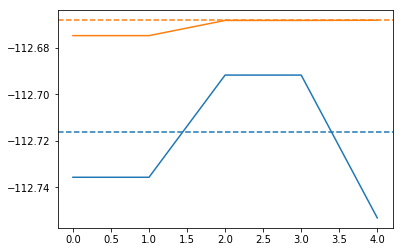

In [315]:
plt.plot(apdft[2:])
plt.plot(apdft_old[2:])
plt.axhline(e_co,color="C0",ls="--")
plt.axhline(eT_R,color="C1",ls="--")

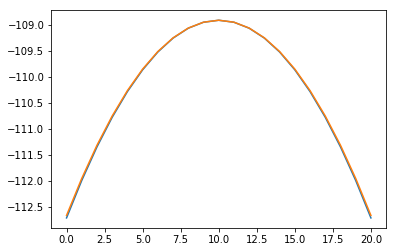

In [300]:
ple=[]
ple0=[]
x=np.linspace(-1,1,21)
for i in x:
    ple.append(E(i))
    ple0.append(E(i,zbs=False))
plt.plot(ple)
plt.plot(ple0)
ple=np.array(ple)
ple0=np.array(ple0)
#plt.axhline(e_co)

In [301]:
scipy.polyfit(x,ple-ple0,10)

array([-8.01088061e-03,  1.89197563e-11,  2.73258157e-02, -4.53081238e-11,
       -3.98680300e-02,  3.58311782e-11,  3.31789297e-02, -1.01953822e-11,
       -6.05843300e-02,  6.76758598e-13, -3.17282051e-06])

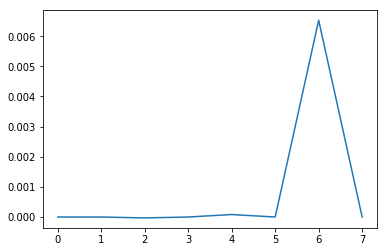

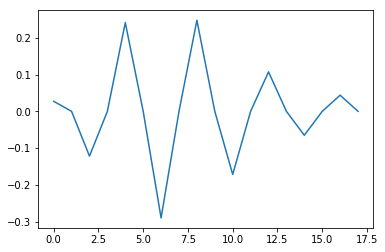

In [303]:
plt.plot(scipy.polyfit(x,ple0,10)[:-3]) #this converges
plt.show()
plt.plot(scipy.polyfit(x,ple,20)[:-3]) #this doesn't

In [299]:
scipy.polyfit(x,ple,20)

array([ 1.22895471e+14,  9.01969433e+10, -4.71684989e+12, -5.95712680e+09,
        7.49129551e+10,  1.44495816e+08, -6.40246121e+08, -1.77208548e+06,
        3.20717584e+06,  1.22806264e+04, -9.61243564e+03, -4.99029739e+01,
        1.69520656e+01,  1.18166128e-01, -8.10252185e-02, -1.55290546e-04,
        4.39538596e-02,  9.93511655e-08, -3.81903746e+00, -1.98389443e-11,
       -1.08916592e+02])

In [294]:
scipy.polyfit(x,ple,20)

array([ 2.73218362e-02,  3.08326034e-07, -1.21617306e-01, -1.15532548e-06,
        2.41006288e-01,  1.77594172e-06, -2.89544171e-01, -1.45060278e-06,
        2.47539475e-01,  6.81315427e-07, -1.71388236e-01, -1.85700199e-07,
        1.07187970e-01,  2.80541980e-08, -6.49646218e-02, -2.05779271e-09,
        4.39460036e-02,  4.85839141e-11, -3.81903745e+00,  2.29182590e-13,
       -1.08916592e+02])

In [194]:
ple-e_nn

array([-3.79955021, -3.07933012, -2.43444893, -1.86499486, -1.37105646,
       -0.95273048, -0.61013132, -0.34339863, -0.15269508, -0.03818604,
        0.        , -0.03818604, -0.15269508, -0.34339863, -0.61013132,
       -0.95273048, -1.37105646, -1.86499486, -2.43444893, -3.07933012,
       -3.79955021])

In [195]:
-(7+np.linspace(-1,1,11))**(2.4)/2-(7-np.linspace(-1,1,11))**(2.4)/2+7**(2.4)

array([-3.65738512, -2.34107217, -1.31700406, -0.585383  , -0.14635292,
        0.        , -0.14635292, -0.585383  , -1.31700406, -2.34107217,
       -3.65738512])

In [197]:
delta_en=ple-e_nn+(7+x)**(2.4)/2+(7-x)**(2.4)/2-7**(2.4)
delta_en

array([-0.14216509, -0.11661714, -0.09337676, -0.07250136, -0.0540524 ,
       -0.03810318, -0.02474832, -0.01411128, -0.00634216, -0.00159737,
        0.        , -0.00159737, -0.00634216, -0.01411128, -0.02474832,
       -0.03810318, -0.0540524 , -0.07250136, -0.09337676, -0.11661714,
       -0.14216509])

In [198]:
scipy.polyfit(x,delta_en,10)

array([-8.01100911e-03, -2.26598695e-12,  2.72959035e-02,  3.57382592e-12,
       -3.97900578e-02, -1.99141903e-12,  3.82149107e-02,  6.79545065e-13,
       -1.59871850e-01, -1.31017536e-13, -3.17293469e-06])

In [199]:
scipy.polyfit(x,ple,10)

array([-8.01100889e-03, -2.96368549e-12,  2.72959290e-02,  5.46190026e-12,
       -3.97858316e-02, -3.45133477e-12,  3.97083323e-02,  1.04312063e-12,
       -3.81875464e+00, -1.52582720e-13, -1.08916595e+02])

In [203]:
E(.999),E(1)

(-112.70856699788524, -112.71614182671563)

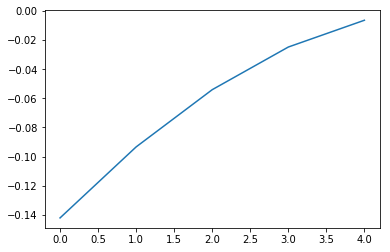

In [87]:
plt.plot(delta_en[:5])

In [88]:
rat_en=ple/((7+np.linspace(-1,1,11))**(2.4)/2+(7-np.linspace(-1,1,11))**(2.4)/2)

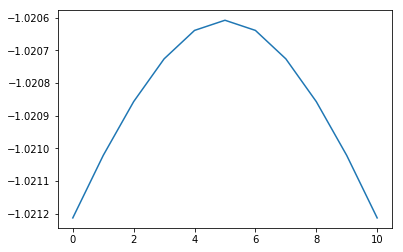

In [91]:
plt.plot(rat_en)

In [90]:
scipy.polyfit(np.linspace(-1,1,21),rat_en,10)

array([-1.44749043e-04,  7.01783467e-13,  4.05604935e-04, -1.49329390e-12,
       -4.83360656e-04,  1.02961911e-12,  4.11172786e-04, -2.56355637e-13,
       -7.93838822e-04,  1.67459233e-14, -1.02060748e+00])

In [161]:
def func(l,a,b):
    return (-(7+l)**(2.4)/2-(7-l)**(2.4)/2+7**(2.4))*a+\
            (-(7+l)**(2.3)/2-(7-l)**(2.3)/2+7**(2.3))*b+e_nn

In [162]:
func(1,1,.0),e_co


(-112.57397673610315, -112.716141826715)

In [172]:
scipy.optimize.curve_fit(func, np.linspace(-1,1,11)[4:7], ple[4:7],p0=[.5,.5])


(array([0.6852106 , 0.48888935]), array([[inf, inf],
        [inf, inf]]))

In [173]:
func(-1, 0.6852106 , 0.48888935 ),e_co

(-112.7325327222326, -112.716141826715)

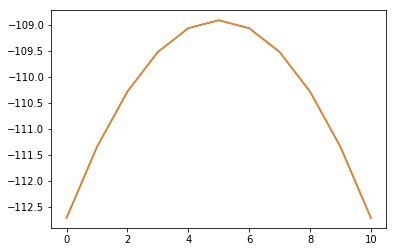

In [167]:
plt.plot(func(np.linspace(-1,1,11),66.15529149, -88.8886787  ))
plt.plot(ple)

Very unpleasent results, the inclusion of a z^2.4 term does't improve quality of the prediction because is absorbed by the taylor series also rational serie doesn't converge better than the standard.
Only idea is trying predict the density matrix :(